# Geopandas

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # Author: don't skip this
# pyLDAvis.gensim.prepare

# I think i need another one:
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Geopandas

import pandas as pd
import geopandas as gpd
import cbsodata

In [4]:
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/dataset_10012022_cleaned.csv', index_col=1) 
df1 = pd.read_csv('/Users/dj/Python - UvA/DSP/data/2021_full.csv', index_col=1) 

df_be = df[df['bewijs'] != '[]'] #bewijs
df_te = df[df['tll'] != '[]'] #tenlastelegging

df['bete'] = df['bewijs'] + df['tll'] 
df = df[df['bete'] != '[][]']
df = df.drop(labels=['bewijs', 'tll'], axis=1)

In [9]:
# Find out which columns are available
metadata = pd.DataFrame(cbsodata.get_meta('83765NED', 'DataProperties'))

# Download birth rates and delete spaces from regional identifiers
data = pd.DataFrame(cbsodata.get_data('83765NED', select = ['WijkenEnBuurten', 'Codering_3', 'GeboorteRelatief_25']))
data['Codering_3'] = data['Codering_3'].str.strip()

# Retrieve data with municipal boundaries from PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
municipal_boundaries = gpd.read_file(geodata_url)


In [10]:
municipal_boundaries.head()

,id,statcode,statnaam,jrstatcode,rubriek,geometry
0,cbs_gemeente_2017_gegeneraliseerd.227606,GM0003,Appingedam,2017GM0003,gemeente,"MULTIPOLYGON (((254580.674 594573.506, 254603...."
1,cbs_gemeente_2017_gegeneraliseerd.227607,GM0005,Bedum,2017GM0005,gemeente,"MULTIPOLYGON (((235432.131 595115.625, 236140...."
2,cbs_gemeente_2017_gegeneraliseerd.227608,GM0007,Bellingwedde,2017GM0007,gemeente,"MULTIPOLYGON (((276518.068 566843.126, 276412...."
3,cbs_gemeente_2017_gegeneraliseerd.227609,GM0009,Ten Boer,2017GM0009,gemeente,"MULTIPOLYGON (((245194.691 592594.007, 245002...."
4,cbs_gemeente_2017_gegeneraliseerd.227610,GM0010,Delfzijl,2017GM0010,gemeente,"MULTIPOLYGON (((262016.555 587782.309, 262403...."


In [33]:
# Link data from Statistics Netherlands to geodata
municipal_boundaries = pd.merge(municipal_boundaries, data,
                               left_on = "statcode", 
                               right_on = "Codering_3")

municipal_boundaries.head()

,id,statcode,statnaam,jrstatcode,rubriek,geometry,WijkenEnBuurten_x,Codering_3_x,GeboorteRelatief_25_x,WijkenEnBuurten_y,Codering_3_y,GeboorteRelatief_25_y,WijkenEnBuurten,Codering_3,GeboorteRelatief_25
0,cbs_gemeente_2017_gegeneraliseerd.227606,GM0003,Appingedam,2017GM0003,gemeente,"MULTIPOLYGON (((254580.674 594573.506, 254603....",Appingedam,GM0003,7,Appingedam,GM0003,7,Appingedam,GM0003,7
1,cbs_gemeente_2017_gegeneraliseerd.227607,GM0005,Bedum,2017GM0005,gemeente,"MULTIPOLYGON (((235432.131 595115.625, 236140....",Bedum,GM0005,10,Bedum,GM0005,10,Bedum,GM0005,10
2,cbs_gemeente_2017_gegeneraliseerd.227608,GM0007,Bellingwedde,2017GM0007,gemeente,"MULTIPOLYGON (((276518.068 566843.126, 276412....",Bellingwedde,GM0007,7,Bellingwedde,GM0007,7,Bellingwedde,GM0007,7
3,cbs_gemeente_2017_gegeneraliseerd.227609,GM0009,Ten Boer,2017GM0009,gemeente,"MULTIPOLYGON (((245194.691 592594.007, 245002....",Ten Boer,GM0009,6,Ten Boer,GM0009,6,Ten Boer,GM0009,6
4,cbs_gemeente_2017_gegeneraliseerd.227610,GM0010,Delfzijl,2017GM0010,gemeente,"MULTIPOLYGON (((262016.555 587782.309, 262403....",Delfzijl,GM0010,8,Delfzijl,GM0010,8,Delfzijl,GM0010,8


Text(0.5, 1.0, 'Birth rate per 1,000 population, 2017')

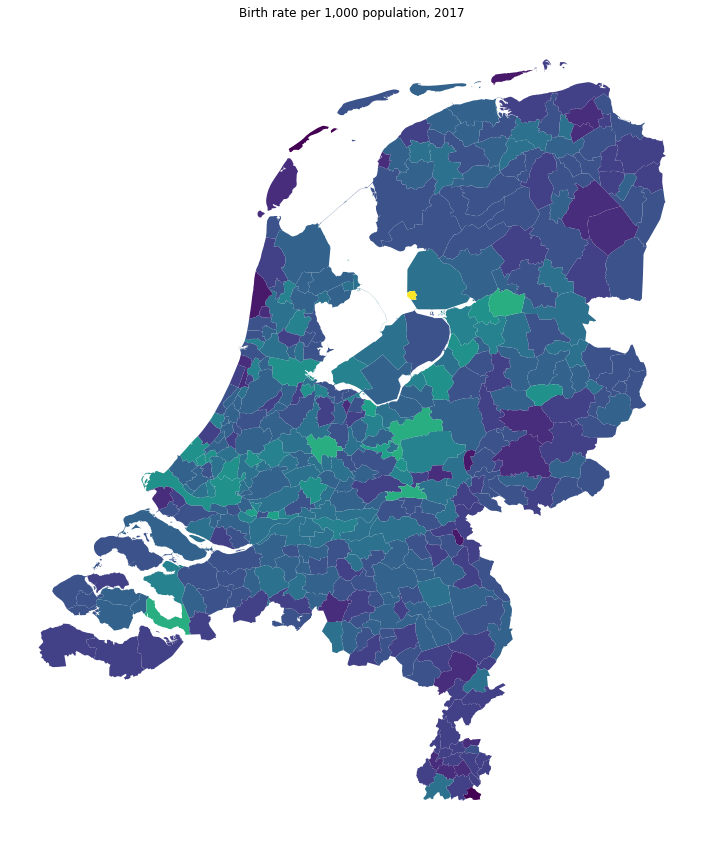

In [7]:
# Create a thematic map
p = municipal_boundaries.plot(column='GeboorteRelatief_25', 
                             figsize = (15,15))
p.axis('off')
p.set_title('Birth rate per 1,000 population, 2017')


# Now for our case 

In [5]:
spat = pd.DataFrame(df1.spatial.value_counts())
spat.reset_index(level=0, inplace=True)

ind = spat['index'] == "'s-Gravenhage"
ind1 = spat['index'] == "'s-Hertogenbosch"
spat['index'][ind] = 'Gravenhage'
spat['index'][ind1] = 'Hertogenbosch'

spat.rename(columns={'index':'statnaam'}, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [6]:
# Retrieve data with municipal boundaries from PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
map = gpd.read_file(geodata_url)

In [7]:
# Link data from Statistics Netherlands to geodata
map_dat = pd.merge(map, spat, how = 'left')
map_dat['spatial'] = map_dat['spatial'].fillna(0)
map_dat

,id,statcode,statnaam,jrstatcode,rubriek,geometry,spatial
0,cbs_gemeente_2017_gegeneraliseerd.227606,GM0003,Appingedam,2017GM0003,gemeente,"MULTIPOLYGON (((254580.674 594573.506, 254603....",0.0
1,cbs_gemeente_2017_gegeneraliseerd.227607,GM0005,Bedum,2017GM0005,gemeente,"MULTIPOLYGON (((235432.131 595115.625, 236140....",0.0
2,cbs_gemeente_2017_gegeneraliseerd.227608,GM0007,Bellingwedde,2017GM0007,gemeente,"MULTIPOLYGON (((276518.068 566843.126, 276412....",0.0
3,cbs_gemeente_2017_gegeneraliseerd.227609,GM0009,Ten Boer,2017GM0009,gemeente,"MULTIPOLYGON (((245194.691 592594.007, 245002....",0.0
4,cbs_gemeente_2017_gegeneraliseerd.227610,GM0010,Delfzijl,2017GM0010,gemeente,"MULTIPOLYGON (((262016.555 587782.309, 262403....",0.0
...,...,...,...,...,...,...,...
383,cbs_gemeente_2017_gegeneraliseerd.227989,GM1942,Gooise Meren,2017GM1942,gemeente,"MULTIPOLYGON (((141177.743 476691.530, 141885....",0.0
384,cbs_gemeente_2017_gegeneraliseerd.227990,GM1945,Berg en Dal,2017GM1945,gemeente,"MULTIPOLYGON (((189500.543 421973.780, 189555....",0.0
385,cbs_gemeente_2017_gegeneraliseerd.227991,GM1948,Meierijstad,2017GM1948,gemeente,"MULTIPOLYGON (((173177.479 400066.891, 172891....",0.0
386,cbs_gemeente_2017_gegeneraliseerd.227992,GM1955,Montferland,2017GM1955,gemeente,"MULTIPOLYGON (((208730.570 435003.510, 208857....",0.0


Text(0.5, 1.0, 'Amount of Crime within a Statnaam')

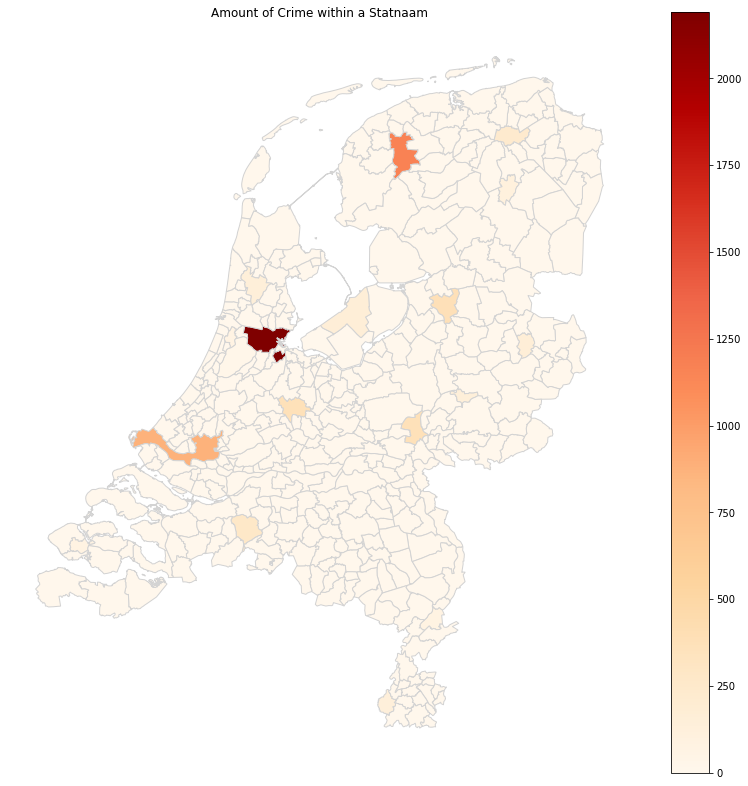

In [8]:
# Create a thematic map
p = map_dat.plot(column='spatial',
figsize = (14,14), 
legend=True,
edgecolor="lightgrey",
cmap='OrRd')

p.axis('off')
p.set_title('Amount of Crime within a Statnaam')

In [9]:
df1.spatial.value_counts()

Amsterdam           2192
Leeuwarden          1172
Rotterdam            879
's-Hertogenbosch     576
Den Haag             433
Zwolle               380
Arnhem               375
Utrecht              370
Breda                280
Groningen            233
Almelo               169
Lelystad             164
Zutphen              147
Alkmaar              146
Maastricht           144
Assen                112
Roermond              79
Middelburg            78
Haarlem               70
's-Gravenhage         59
Haarlemmermeer        27
Enschede               1
Almere                 1
Name: spatial, dtype: int64